In [1]:
%load_ext autoreload
%autoreload

In [2]:
enable_wandb = True
if enable_wandb:
    import wandb
    wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: niklas-kemper. Use `wandb login --relogin` to force relogin


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import graph_tool as gt
import graph_tool.generation as gen
import graph_tool.topology as top
import networkx as nx

In [4]:
from torch_geometric.datasets import TUDataset

In [5]:
from substructures import get_rings, get_substructure_edge_index
def pre_transform(graph):
    triangles = get_rings(graph.edge_index, max_k =3)
    substructures_edge_index = [get_substructure_edge_index(substructure) for substructure in [triangles]]
    return graph.update({"substructures_edge_index": substructures_edge_index, "y": float(len(triangles)), "x": torch.zeros((graph.num_nodes,1))})

In [6]:
DATASET_NAME = "ENZYMES"
dataset = TUDataset(root=f'/tmp/{DATASET_NAME}', name=DATASET_NAME, pre_transform = pre_transform, use_node_attr= True)

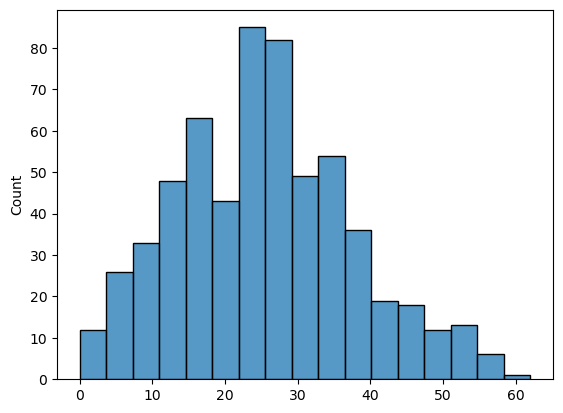

In [7]:
import seaborn as sns
sns.histplot([int(graph.y) for graph in dataset])

In [8]:
from torch_geometric.loader import DataLoader

In [9]:
torch.manual_seed(0)
count_dataset = dataset.shuffle()
train_num = int(len(count_dataset) * 0.6)
val_num = int(len(count_dataset) * 0.2)
train_dataset = count_dataset[:train_num]
val_dataset = count_dataset[train_num:train_num + val_num]
test_dataset = count_dataset[train_num + val_num:]
train_loader = DataLoader(train_dataset, batch_size = 16)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [10]:
import simple_model_triangles as models
model = models.SimpleSubstructureNeuralNetGraph(hidden_channels=16, out_channels=1, in_channels = 1, num_layers=3, num_substructures=1)

In [11]:
print(model)

SimpleSubstructureNeuralNetGraph(
  (layers): ModuleList(
    (0): SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=32, out_features=16, bias=True)
      ))
      (node2substructures): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
      (substructures2node): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
    )
    (1-2): 2 x SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_features=32, 

In [12]:
from trainer import GraphNetGraphPredictions
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger(project='triangle-graph-counting', name= "triangle counting")


trainer = Trainer(max_epochs=400, logger= wandb_logger, enable_progress_bar= False, log_every_n_steps=15)
model_lightning = GraphNetGraphPredictions(model)

trainer.fit(model_lightning, train_dataloaders=train_loader, val_dataloaders= val_loader)
wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SimpleSubstructureNeuralNetGraph | 9.9 K 
-----------------------------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.040     Total estimated model params size (MB)
/Users/niklas/anaconda3/envs/substructureML/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/niklas/anaconda3/envs/substructureML/lib/python3.8/site-packages/pyt

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,█▂▂▂▃▄▂▁▅▁▃▂▁▃▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_acc,▁▂▂▂▁▁▄▇▁▂▂▂▆▃▃▂▁▂▃▅████▂██▃███▇▅▇▃▅████
val_loss,▃█▄▂▁▂▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,399
trainer/global_step,9199
training_loss,0.00081
val_acc,1.0
val_loss,0.00154
